#### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

#### Import the DataSet

In [4]:
df = pd.read_csv('CarPrice_Assignment.csv')

#### Read the DataSet

In [5]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


#### Change CarName column to brand name

In [6]:
df['CarName'] = df['CarName'].apply(lambda x: x.split()[0])

#### Method to correct invalid values

In [7]:
def correct_values(df, col, replacement):
    df[col] = df[col].str.replace(replacement[0], replacement[1])

In [8]:
replacements = [
    ('porcshce','porsche'),
    ('maxda','mazda'),
    ('vokswagen','volkswagen'),
    ('Nissan','nissan'),
    ('toyouta','toyota'),
    ('vw','volkswagen')
]

for val in replacements:
    correct_values(df, 'CarName', val)
    
correct_values(df, 'drivewheel', ('4wd', 'fwd'))

#### Method to augment values with suffix for creating dummies

In [9]:
def augment_values_for_dummies(df, col, suffix):
    df[col] = df[col].apply(lambda x: x + suffix)

In [10]:
augmented_values = [
    ('cylindernumber', '_cylinders'),
    ('doornumber', '_doors')
]

for val in augmented_values:
    augment_values_for_dummies(df, val[0], val[1])

#### Method to convert values to dummies

In [11]:
def convert_to_dummies(df, column):
    new_df = pd.get_dummies(df[column], drop_first=True)
    df = pd.concat([df, new_df], axis=1)
    return df.drop(column, axis=1)

#### Categorical columns

In [12]:
col_list_dummies = [
    'CarName', 
    'fueltype', 
    'aspiration', 
    'carbody', 
    'drivewheel', 
    'enginelocation', 
    'cylindernumber', 
    'doornumber',
    'enginetype',
    'fuelsystem'
]

In [13]:
for col in col_list_dummies:
    df = convert_to_dummies(df, col)

#### Split Data into Training and Test Set

In [14]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

In [15]:
df_train.shape

(143, 65)

In [16]:
df_test.shape

(62, 65)

#### Rescaling the features

In [17]:
scaler = MinMaxScaler()

numeric_cols = ['symboling', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price']

df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_train.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
122,123,0.6,0.244828,0.426016,0.291667,0.265487,0.272692,0.139623,0.230159,0.525253,...,0,0,0,1,0,0,0,0,0,0
125,126,1.0,0.272414,0.452033,0.666667,0.212389,0.500388,0.339623,1.000000,0.464646,...,0,0,0,0,0,0,0,1,0,0
166,167,0.6,0.272414,0.448780,0.308333,0.424779,0.314973,0.139623,0.444444,0.449495,...,0,0,0,0,0,0,0,1,0,0
1,2,1.0,0.068966,0.450407,0.316667,0.088496,0.411171,0.260377,0.626984,0.247475,...,0,0,0,0,0,0,0,1,0,0
199,200,0.2,0.610345,0.775610,0.575000,0.858407,0.647401,0.260377,0.746032,0.484848,...,0,0,0,0,0,0,0,1,0,0


#### Find correlation between variables

In [18]:
df_train[numeric_cols].corr()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,1.000000,-0.539877,-0.390880,-0.263917,-0.557179,-0.268481,-0.182393,-0.132768,-0.028788,-0.266962,0.038395,0.343449,-0.042737,0.022248,-0.129859
wheelbase,-0.539877,1.000000,0.877909,0.796888,0.555524,0.792815,0.588600,0.482386,0.224970,0.341651,0.382758,-0.347757,-0.476317,-0.542295,0.622591
carlength,-0.390880,0.877909,1.000000,0.846307,0.454721,0.881495,0.702794,0.620436,0.176814,0.227958,0.564588,-0.301036,-0.674112,-0.704482,0.713749
carwidth,-0.263917,0.796888,0.846307,1.000000,0.245022,0.873884,0.754925,0.580962,0.233631,0.249516,0.685051,-0.188153,-0.652871,-0.680451,0.799380
carheight,-0.557179,0.555524,0.454721,0.245022,1.000000,0.272388,0.045042,0.160835,0.003588,0.289830,-0.151952,-0.358919,-0.006993,-0.073803,0.096631
curbweight,-0.268481,0.792815,0.881495,0.873884,0.272388,1.000000,0.865102,0.625759,0.209277,0.231862,0.759759,-0.278156,-0.743870,-0.780075,0.861860
enginesize,-0.182393,0.588600,0.702794,0.754925,0.045042,0.865102,1.000000,0.545157,0.228768,0.119246,0.817916,-0.265202,-0.627421,-0.646354,0.867915
boreratio,-0.132768,0.482386,0.620436,0.580962,0.160835,0.625759,0.545157,1.000000,-0.152836,0.116317,0.518307,-0.287938,-0.540514,-0.534084,0.533591
stroke,-0.028788,0.224970,0.176814,0.233631,0.003588,0.209277,0.228768,-0.152836,1.000000,0.212200,0.106454,-0.017408,-0.073561,-0.057608,0.152820
compressionratio,-0.266962,0.341651,0.227958,0.249516,0.289830,0.231862,0.119246,0.116317,0.212200,1.000000,-0.130565,-0.456612,0.260428,0.210307,0.160847


#### Plot a Heatmap for the correlations

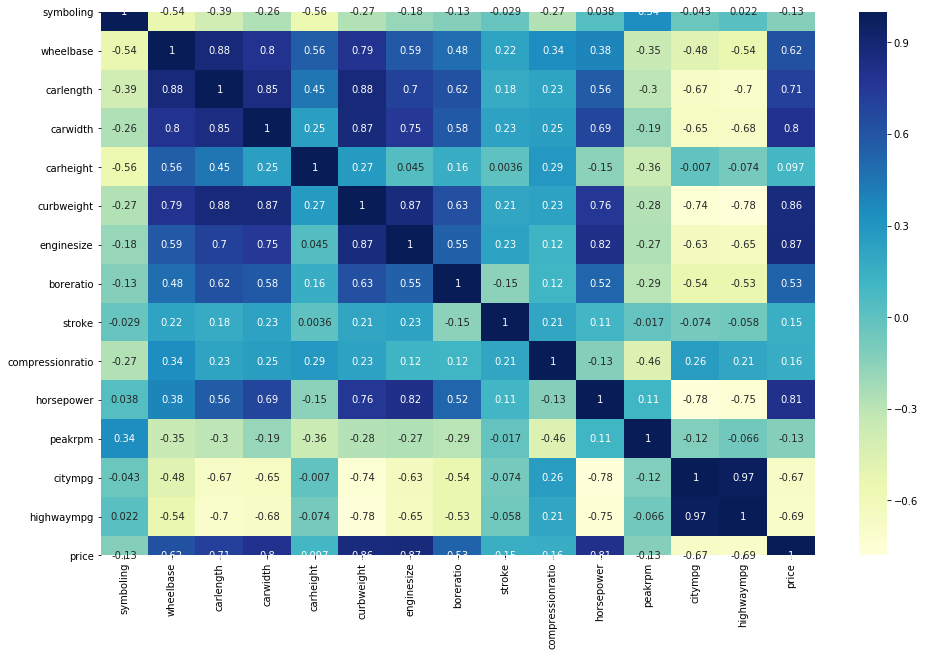

In [19]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train[numeric_cols].corr(), annot=True, cmap='YlGnBu')
plt.show()

#### Split the training DataSet into dependent and independent variables

In [20]:
df_train.pop('car_ID')
y_train = df_train.pop('price')
X_train = df_train

#### Use Linear Regression from sklearn

In [21]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

In [22]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('symboling', False, 49),
 ('wheelbase', False, 17),
 ('carlength', False, 21),
 ('carwidth', True, 1),
 ('carheight', False, 18),
 ('curbweight', True, 1),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', False, 2),
 ('compressionratio', False, 25),
 ('horsepower', False, 15),
 ('peakrpm', False, 16),
 ('citympg', False, 39),
 ('highwaympg', False, 26),
 ('audi', False, 37),
 ('bmw', True, 1),
 ('buick', False, 38),
 ('chevrolet', False, 23),
 ('dodge', False, 20),
 ('honda', False, 22),
 ('isuzu', False, 50),
 ('jaguar', False, 27),
 ('mazda', False, 44),
 ('mercury', False, 51),
 ('mitsubishi', False, 13),
 ('nissan', False, 43),
 ('peugeot', False, 6),
 ('plymouth', False, 19),
 ('porsche', True, 1),
 ('renault', False, 40),
 ('saab', False, 9),
 ('subaru', False, 11),
 ('toyota', False, 45),
 ('volkswagen', False, 46),
 ('volvo', False, 8),
 ('gas', False, 24),
 ('turbo', False, 14),
 ('hardtop', False, 31),
 ('hatchback', False, 30),
 ('sedan', False, 32),
 ('wagon

In [23]:
selected_cols = X_train.columns[rfe.support_]
selected_cols = selected_cols.tolist()
selected_cols

['carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'bmw',
 'porsche',
 'rear',
 'three_cylinders',
 'twelve_cylinders',
 'two_cylinders']

#### Use statsmodel api for detailed statistics

#### Get selected columns from Recursive feature elimination

In [24]:
X_train_rfe = X_train[selected_cols]

#### Add a constant variable to statsmodel api

In [25]:
X_train_rfe = sm.add_constant(X_train_rfe)

#### Run the linear model

In [26]:
lm = sm.OLS(y_train, X_train_rfe).fit()

#### Print statsmodel summary

In [27]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     137.1
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.21e-64
Time:                        22:21:43   Log-Likelihood:                 190.87
No. Observations:                 143   AIC:                            -359.7
Df Residuals:                     132   BIC:                            -327.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1594      0.019     -8.597      0.000      -0.196      -0.123
carwidth             0.3283      0.067      4.910      0.000       0.196       0.461
curbweight           0.2989      0.080      3.729      0.000       0.140       0.457
enginesize           0.5732      0.097      5.926      0.000       0.382       0.764
boreratio           -0.1088      0.037     -2.976      0.003      -0.181      -0.036
bmw                  0.2453      0.029      8.327      0.000       0.187       0.304
porsche              0.1565      0.052      3.000      0.003       0.053       0.260
rear                 0.3298      0.086      3.844      0.000       0.160       0.500
three_cylinders      0.1802      0.068      2.638      0.009       0.045       0.315
twelve_cylinders    -0.0536      0.081     -0.659      0.511      -0.214       0.107
two_cylinders        0.1542      0.037      4.123      0.000       0.080       0.228
==============================================================================
Omnibus:                       10.995   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.683
Skew:                           0.423   Prob(JB):                     0.000393
Kurtosis:                       4.385   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
X_train_new = X_train_rfe

#### Calculate VIFs for the model

In [29]:
vif = pd.DataFrame()
X = X_train_new.drop('const', axis = 1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,curbweight,41.06
0,carwidth,25.19
2,enginesize,24.95
3,boreratio,9.78
5,porsche,1.67
6,rear,1.61
8,twelve_cylinders,1.50
9,two_cylinders,1.27
4,bmw,1.18
7,three_cylinders,1.01


#### Remove columns manually

In [30]:
X_train_rfe = pd.DataFrame()

In [31]:
def rebuild_model(remove_col, selected_cols, X_train, sm, y_train, X_train_rfe):
    selected_cols.remove(remove_col)
    X_train_rfe = X_train[selected_cols]
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(y_train, X_train_rfe).fit()
    return lm, X_train_rfe
    
def calculate_VIF(pd, X_train_rfe):
    vif = pd.DataFrame()
    X = X_train_rfe.drop('const', axis = 1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

In [32]:
lm, X_train_rfe = rebuild_model('curbweight', selected_cols, X_train, sm, y_train, X_train_rfe)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     137.4
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           7.17e-63
Time:                        22:21:43   Log-Likelihood:                 183.70
No. Observations:                 143   AIC:                            -347.4
Df Residuals:                     133   BIC:                            -317.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1774      0.019     -9.459      0.000      -0.215      -0.140
carwidth             0.4725      0.057      8.264      0.000       0.359       0.586
enginesize           0.8075      0.077     10.485      0.000       0.655       0.960
boreratio           -0.0733      0.037     -1.984      0.049      -0.146      -0.000
bmw                  0.2406      0.031      7.806      0.000       0.180       0.302
porsche              0.1001      0.052      1.914      0.058      -0.003       0.203
rear                 0.3474      0.090      3.872      0.000       0.170       0.525
three_cylinders      0.1917      0.071      2.682      0.008       0.050       0.333
twelve_cylinders    -0.1324      0.082     -1.610      0.110      -0.295       0.030
two_cylinders        0.1859      0.038      4.873      0.000       0.110       0.261
==============================================================================
Omnibus:                        8.294   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.605
Skew:                           0.459   Prob(JB):                       0.0135
Kurtosis:                       3.776   Cond. No.                         24.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
calculate_VIF(pd, X_train_rfe)

,Features,VIF
0,carwidth,17.88
1,enginesize,13.64
2,boreratio,9.52
5,rear,1.61
4,porsche,1.59
7,twelve_cylinders,1.40
8,two_cylinders,1.20
3,bmw,1.18
6,three_cylinders,1.01


In [34]:
lm, X_train_rfe = rebuild_model('carwidth', selected_cols, X_train, sm, y_train, X_train_rfe)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     97.25
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.38e-52
Time:                        22:21:43   Log-Likelihood:                 154.07
No. Observations:                 143   AIC:                            -290.1
Df Residuals:                     134   BIC:                            -263.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0994      0.020     -5.004      0.000      -0.139      -0.060
enginesize           1.2558      0.067     18.741      0.000       1.123       1.388
boreratio           -0.0047      0.044     -0.105      0.916      -0.092       0.083
bmw                  0.1884      0.037      5.096      0.000       0.115       0.262
porsche              0.1509      0.064      2.370      0.019       0.025       0.277
rear                 0.1209      0.105      1.155      0.250      -0.086       0.328
three_cylinders      0.1012      0.087      1.169      0.245      -0.070       0.272
twelve_cylinders    -0.3000      0.098     -3.071      0.003      -0.493      -0.107
two_cylinders        0.2656      0.045      5.872      0.000       0.176       0.355
==============================================================================
Omnibus:                       16.109   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.507
Skew:                           0.607   Prob(JB):                     7.86e-06
Kurtosis:                       4.572   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
calculate_VIF(pd, X_train_rfe)

,Features,VIF
0,enginesize,6.98
1,boreratio,6.40
3,porsche,1.59
4,rear,1.51
6,twelve_cylinders,1.29
2,bmw,1.12
7,two_cylinders,1.12
5,three_cylinders,1.01


In [36]:
lm, X_train_rfe = rebuild_model('three_cylinders', selected_cols, X_train, sm, y_train, X_train_rfe)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     110.6
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           9.66e-53
Time:                        22:21:43   Log-Likelihood:                 153.35
No. Observations:                 143   AIC:                            -290.7
Df Residuals:                     135   BIC:                            -267.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0955      0.020     -4.870      0.000      -0.134      -0.057
enginesize           1.2483      0.067     18.690      0.000       1.116       1.380
boreratio           -0.0076      0.044     -0.172      0.864      -0.095       0.080
bmw                  0.1894      0.037      5.116      0.000       0.116       0.263
porsche              0.1532      0.064      2.405      0.018       0.027       0.279
rear                 0.1209      0.105      1.153      0.251      -0.086       0.328
twelve_cylinders    -0.2944      0.098     -3.013      0.003      -0.488      -0.101
two_cylinders        0.2635      0.045      5.823      0.000       0.174       0.353
==============================================================================
Omnibus:                       15.915   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.318
Skew:                           0.619   Prob(JB):                     1.42e-05
Kurtosis:                       4.488   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
calculate_VIF(pd, X_train_rfe)

,Features,VIF
0,enginesize,6.95
1,boreratio,6.37
3,porsche,1.59
4,rear,1.51
5,twelve_cylinders,1.29
2,bmw,1.12
6,two_cylinders,1.12


In [38]:
lm, X_train_rfe = rebuild_model('boreratio', selected_cols, X_train, sm, y_train, X_train_rfe)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     130.0
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           8.22e-54
Time:                        22:21:43   Log-Likelihood:                 153.33
No. Observations:                 143   AIC:                            -292.7
Df Residuals:                     136   BIC:                            -271.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0977      0.015     -6.617      0.000      -0.127      -0.069
enginesize           1.2420      0.056     22.306      0.000       1.132       1.352
bmw                  0.1896      0.037      5.141      0.000       0.117       0.262
porsche              0.1505      0.062      2.443      0.016       0.029       0.272
rear                 0.1225      0.104      1.177      0.241      -0.083       0.328
twelve_cylinders    -0.2911      0.095     -3.050      0.003      -0.480      -0.102
two_cylinders        0.2621      0.044      5.913      0.000       0.174       0.350
==============================================================================
Omnibus:                       15.791   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.096
Skew:                           0.615   Prob(JB):                     1.59e-05
Kurtosis:                       4.482   Cond. No.                         16.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
calculate_VIF(pd, X_train_rfe)

,Features,VIF
2,porsche,1.56
3,rear,1.50
0,enginesize,1.29
1,bmw,1.11
4,twelve_cylinders,1.11
5,two_cylinders,1.00


In [40]:
lm, X_train_rfe = rebuild_model('rear', selected_cols, X_train, sm, y_train, X_train_rfe)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.3
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.24e-54
Time:                        22:21:43   Log-Likelihood:                 152.61
No. Observations:                 143   AIC:                            -293.2
Df Residuals:                     137   BIC:                            -275.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0982      0.015     -6.645      0.000      -0.127      -0.069
enginesize           1.2442      0.056     22.328      0.000       1.134       1.354
bmw                  0.1892      0.037      5.123      0.000       0.116       0.262
porsche              0.1909      0.051      3.721      0.000       0.089       0.292
twelve_cylinders    -0.2928      0.096     -3.064      0.003      -0.482      -0.104
two_cylinders        0.2625      0.044      5.914      0.000       0.175       0.350
==============================================================================
Omnibus:                       15.023   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.294
Skew:                           0.603   Prob(JB):                     3.92e-05
Kurtosis:                       4.396   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
calculate_VIF(pd, X_train_rfe)

,Features,VIF
0,enginesize,1.29
1,bmw,1.11
3,twelve_cylinders,1.11
2,porsche,1.07
4,two_cylinders,1.00


#### Residual Analysis

In [42]:
y_train_pred = lm.predict(X_train_rfe)
res = y_train - y_train_pred

#### Plot the errors

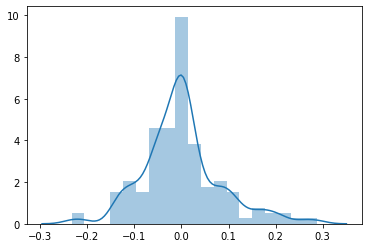

In [43]:
sns.distplot(res)

#### Predictions and evaluations on Test DataSet

In [44]:
numeric_cols = ['symboling', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price']

df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])
df_test.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
160,161,0.4,0.313793,0.409756,0.341667,0.460177,0.235066,0.139623,0.404762,0.424242,...,0,0,0,1,0,0,0,0,0,0
186,187,0.8,0.368966,0.497561,0.433333,0.699115,0.305275,0.181132,0.404762,0.611111,...,0,0,0,0,0,0,0,1,0,0
59,60,0.6,0.420690,0.596748,0.516667,0.522124,0.347944,0.230189,0.563492,0.606061,...,0,0,0,1,0,0,0,0,0,0
165,166,0.6,0.272414,0.448780,0.308333,0.424779,0.301396,0.139623,0.444444,0.449495,...,0,0,0,0,0,0,0,1,0,0
140,141,0.8,0.231034,0.263415,0.291667,0.699115,0.291699,0.177358,0.746032,0.227273,...,1,0,0,1,0,0,0,0,0,0


In [45]:
df_test.pop('car_ID')
y_test = df_test.pop('price')
X_test = df_test

In [46]:
X_test_new = X_test[X_train_rfe.columns.tolist()[1:]]
X_test_new = sm.add_constant(X_test_new)

In [47]:
y_test_pred = lm.predict(X_test_new)

#### Model Evaluation

In [48]:
r2_score(y_test, y_test_pred)

0.8456278752816553

#### This r2_score is close to the r squared of the training data set.

In [49]:
df_result = pd.concat([pd.concat([X_test_new, y_test], axis = 1), y_test_pred], axis = 1)
df_result.columns = ['const', 'enginesize', 'BMW', 'rear', '12 Cylinders', 'rotor', 'Actual Price', 'Predicted Price']
df_result

,const,enginesize,BMW,rear,12 Cylinders,rotor,Actual Price,Predicted Price
160,1.0,0.139623,0,0,0,0,0.072382,0.075501
186,1.0,0.181132,0,0,0,0,0.093295,0.127148
59,1.0,0.230189,0,0,0,0,0.102964,0.188185
165,1.0,0.139623,0,0,0,0,0.115479,0.075501
140,1.0,0.177358,0,0,0,0,0.068652,0.122452
...,...,...,...,...,...,...,...,...
28,1.0,0.230189,0,0,0,0,0.105064,0.188185
29,1.0,0.358491,0,0,0,0,0.216758,0.347820
182,1.0,0.135849,0,0,0,0,0.073404,0.070806
40,1.0,0.184906,0,0,0,0,0.143023,0.131843


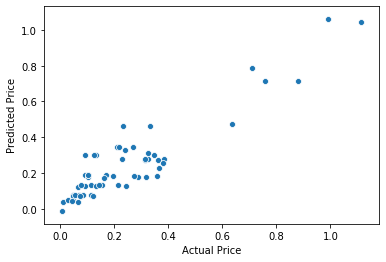

In [50]:
sns.scatterplot(x="Actual Price", y="Predicted Price", data=df_result)

#### R-squared - 0.850
#### Adjusted R-squared - 0.845
#### r2_score (model evaluation) - 0.845

#### The above curve shows that the predicted and actual values almost lie on a straight line in the scatterplot. Hence, out model is fairly accuate in prediction with some residual error.

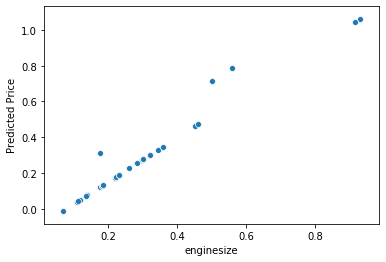

In [51]:
sns.scatterplot(x="enginesize", y="Predicted Price", data=df_result)

#### We can observe that the relation between enginesize and the price is fairly straightforward, higher enginesize attracts greater price.

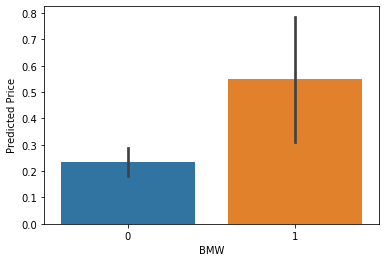

In [52]:
sns.barplot(x="BMW", y="Predicted Price", data=df_result)

#### BMW as a brand holds higher value in the market and attracts better price.

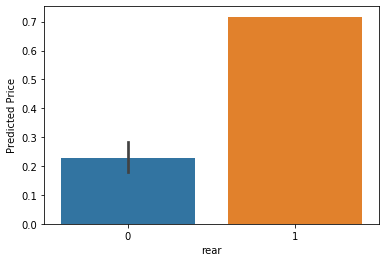

In [53]:
sns.barplot(x="rear", y="Predicted Price", data=df_result)

#### Rear engine location is higher priced.